In [21]:
import numpy as np
import math
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import kstest,norm
from scipy.stats import lognorm
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [24]:
path = Path.cwd().parent.parent
filePath = str(path) + "/data_cleanup/second_dataset/train_data_price_corrected.parquet"
df = pd.read_parquet(filePath)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10305 entries, 0 to 31633
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   reservation_id           10305 non-null  int64         
 1   stay_date                10305 non-null  datetime64[ns]
 2   guest_id                 10305 non-null  int64         
 3   guest_country_id         10305 non-null  object        
 4   reservation_status       10305 non-null  object        
 5   reservation_date         10305 non-null  datetime64[ns]
 6   date_from                10305 non-null  datetime64[ns]
 7   date_to                  10305 non-null  datetime64[ns]
 8   cancel_date              0 non-null      object        
 9   room_cnt                 10305 non-null  int64         
 10  adult_cnt                10305 non-null  int64         
 11  children_cnt             10305 non-null  int64         
 12  price                    10305 non-nu

In [30]:
room_occupancy = df[(df["cancel_date"].isna())]

dates = []
for index, row in room_occupancy.iterrows():
    delta = (row["date_to"] - row["date_from"]).days
    for i in range(delta):
        dates.append((row["date_from"] + pd.Timedelta(days=i), row["room_cnt"]))

# Pretvaranje u DataFrame
room_dates_df = pd.DataFrame(dates, columns=["date", "room_cnt"])

# Grupiranje po datumu i sumiranje broja gostiju
room_occupancy = room_dates_df.groupby("date")["room_cnt"].sum().reset_index()

room_occupancy.head()

,date,room_cnt
0,2007-12-13,1
1,2007-12-14,1
2,2008-01-01,21
3,2008-01-02,3
4,2008-01-03,17


In [37]:
# Kreiramo funkciju koja će postaviti vrijednost is_holiday na True ako je datum praznik, inače False

    # Primjeri praznika (možete nadograditi ovisno o potrebama)
holidays = [
    "2008-01-01",  # Nova godina
    "2008-01-06",  # Bogojavljenje
    "2008-03-24",  # Uskrsni ponedjeljak
    "2008-04-25",  # Dan oslobođenja Italije
    "2008-05-01",  # Praznik rada
    "2008-06-02",  # Republika
    "2008-08-15",  # Velika Gospa
    "2008-11-01",  # Svi Sveti
    "2008-12-08",  # Bezgrešno začeće
    "2008-12-25",  # Božić
    "2008-12-26",  # Sveti Stjepan
    "2009-01-06",  # Sveta tri kralja (Italija, Hrvatska)
    "2009-04-13",  # Uskrsni ponedjeljak
    "2009-04-25",  # Dan oslobođenja Italije
    "2009-05-01",  # Praznik rada
    "2009-06-02",  # Republika
    "2009-08-15",  # Velika Gospa
    "2009-11-01",  # Svi Sveti
    "2009-12-08",  # Bezgrešno začeće
    "2009-12-25",  # Božić
    "2009-12-26",  # Sveti Stjepan
    "2008-01-06",  # Sveta tri kralja (Hrvatska)
    "2008-05-01",  # Praznik rada (Hrvatska)
    "2008-06-22",  # Dan antifašističke borbe (Hrvatska)
    "2008-06-25",  # Dan državnosti (Hrvatska)
    "2008-08-05",  # Dan pobjede i domovinske zahvalnosti (Hrvatska)
    "2008-10-08",  # Dan neovisnosti (Hrvatska)
    "2009-01-01",  # Nova godina (Hrvatska, Engleska)
    "2009-04-10",  # Veliki petak (Engleska)
    "2009-05-04",  # Proljetni praznik (Engleska)
    "2009-05-25",  # Uskršnji ponedjeljak (Engleska)
    "2009-08-31"   # Dan bankarstva (Engleska)
]
   

room_occupancy['is_holiday'] = 0
room_occupancy.loc[room_occupancy['date'].isin(holidays), 'is_holiday'] = 1
room_occupancy.head()

,date,room_cnt,is_holiday
0,2007-12-13,1,0
1,2007-12-14,1,0
2,2008-01-01,21,1
3,2008-01-02,3,0
4,2008-01-03,17,0


In [42]:
room_occupancy.index = room_occupancy["date"]
del room_occupancy["date"]
room_occupancy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 735 entries, 2007-12-13 to 2010-01-02
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   room_cnt    735 non-null    int64
 1   is_holiday  735 non-null    int64
dtypes: int64(2)
memory usage: 17.2 KB


In [43]:
test = room_occupancy.iloc[2:368]
train = room_occupancy.iloc[368:-1]
print(test.shape, train.shape)

(366, 2) (366, 2)


In [45]:
model = auto_arima(room_occupancy['room_cnt'], exogenous=room_occupancy[['is_holiday']], seasonal = True, trace = True, approx = False, m = 7)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=6490.614, Time=1.72 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=6905.852, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=6561.238, Time=0.41 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=6640.701, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=8072.013, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=6582.431, Time=1.32 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=6567.080, Time=0.97 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=6481.493, Time=2.51 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=6544.762, Time=2.15 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=2.92 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=6481.156, Time=2.84 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=6575.814, Time=2.43 sec
 ARIMA(1,0,2)(1,0,2)[7] intercept   : AIC=6484.530, Time=2.52 sec
 ARIMA(2,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(3,0,2)(1,0,2)[7] intercept   : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  735
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -3231.663
Date:                           Fri, 26 Apr 2024   AIC                           6475.325
Time:                                   02:56:49   BIC                           6502.924
Sample:                                        0   HQIC                          6485.970
                                           - 735                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4993      0.036     41.241      0.000       1.428       1.571
ar.L2         -0.5019      0.036    -14.076      0.000      -0.572      -0.432
ma.L1         -0.9665      0.017    -57.837      0.000      -0.999      -0.934
ar.S.L7        0.9561      0.016     59.081      0.000       0.924       0.988
ma.S.L7       -0.8081      0.036    -22.420      0.000      -0.879      -0.737
sigma2       382.6962     18.558     20.621      0.000     346.322     419.070
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                18.82
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.12
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = SARIMAX(room_occupancy['room_cnt'], exog=room_occupancy[['is_holiday']],
              order=(2, 0, 1),              # ARIMA(2,0,1)
              seasonal_order=(1, 0, 1, 7))  # SARIMA(1,0,1,7)
results = mod.fit()

# Ispisivanje sažetka modela
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.58745D+00    |proj g|=  8.41345D-02

At iterate    5    f=  4.54077D+00    |proj g|=  2.60481D-02

At iterate   10    f=  4.50552D+00    |proj g|=  6.94474D-03

At iterate   15    f=  4.47586D+00    |proj g|=  1.89096D-02

At iterate   20    f=  4.39989D+00    |proj g|=  6.13943D-03

At iterate   25    f=  4.39859D+00    |proj g|=  2.30489D-03

At iterate   30    f=  4.39509D+00    |proj g|=  1.39795D-03

At iterate   35    f=  4.39490D+00    |proj g|=  8.85515D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [57]:
start = len(room_occupancy)
end = len(test) + len(room_occupancy) - 1

pred = results.get_forecast(steps=len(test), exog=test[['is_holiday']])

# Ispisivanje predikcija
print(pred.predicted_mean)

# Ako želite izračunati stvarne vrijednosti iz predikcija u logaritamskoj skali
prediction_list = list(train['room_cnt'])  # kopiramo početne vrijednosti
for i, prediction in enumerate(pred.predicted_mean):
    prediction_list.append(prediction_list[-1] + prediction)  # dodajemo predikcije na postojeće vrijednosti

# Prikaz stvarnih vrijednosti
print(prediction_list)

735     19.514481
736     17.958167
737     28.077274
738     30.922979
739     38.117121
          ...    
1096     2.231312
1097     1.756859
1098     0.692975
1099     0.272197
1100    -0.052443
Name: predicted_mean, Length: 366, dtype: float64
[85, 48, 42, 12, 9, 8, 13, 21, 29, 17, 18, 21, 42, 38, 40, 44, 31, 12, 24, 50, 67, 59, 41, 24, 50, 26, 59, 51, 42, 40, 23, 23, 13, 49, 61, 40, 42, 18, 23, 6, 35, 49, 95, 77, 61, 29, 27, 56, 63, 62, 32, 26, 82, 16, 32, 35, 55, 35, 18, 11, 18, 51, 60, 54, 48, 25, 28, 28, 42, 44, 59, 57, 42, 25, 22, 30, 37, 57, 44, 24, 19, 17, 44, 48, 48, 37, 27, 16, 15, 24, 71, 93, 85, 23, 26, 35, 60, 58, 68, 58, 41, 43, 42, 22, 36, 47, 80, 42, 28, 34, 71, 75, 79, 67, 48, 51, 52, 89, 76, 67, 37, 34, 34, 37, 71, 84, 86, 95, 68, 45, 62, 78, 66, 86, 54, 97, 25, 42, 111, 40, 70, 108, 110, 107, 17, 57, 42, 83, 61, 44, 46, 92, 108, 45, 55, 55, 68, 43, 72, 117, 81, 31, 54, 101, 99, 16, 93, 61, 54, 57, 68, 57, 17, 57, 41, 49, 30, 88, 82, 87, 111, 83, 49, 34, 68, 41, 50

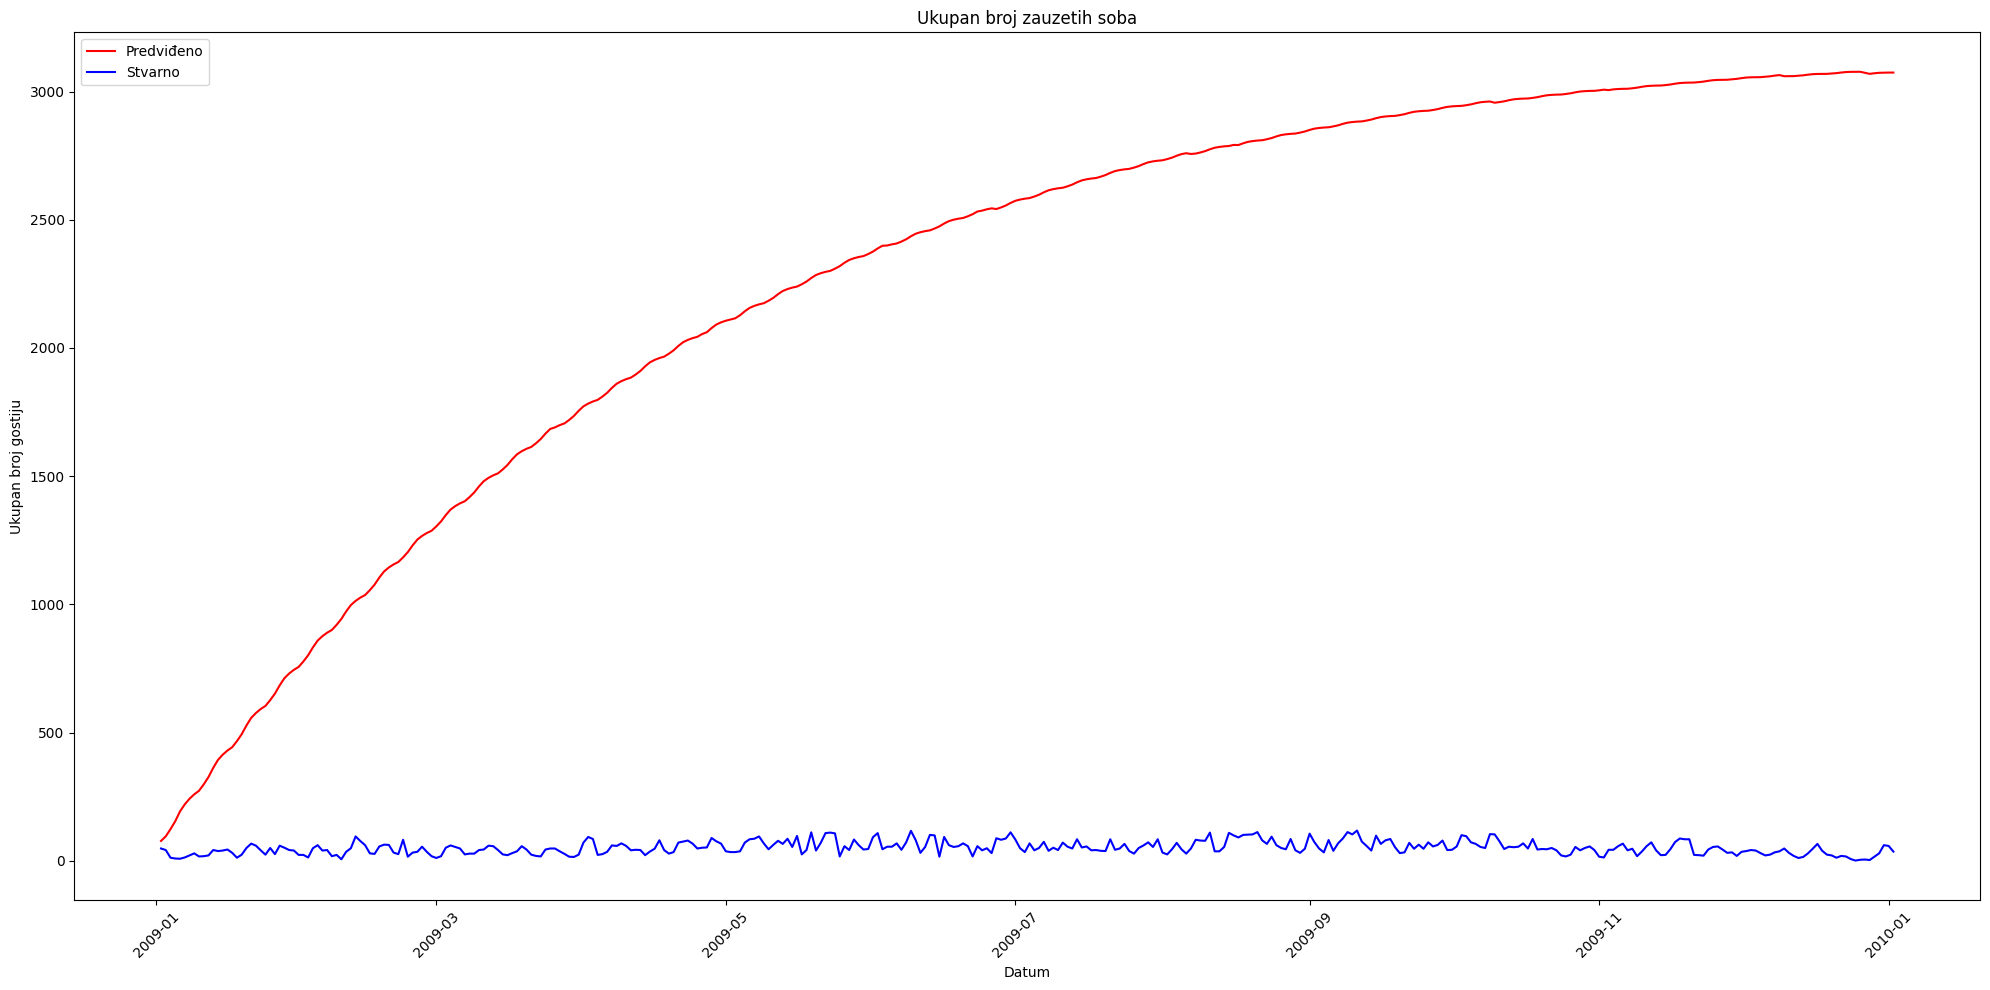

In [60]:

# Podaci za testiranje modela
test_data = room_occupancy.iloc[369:]  # Preostali redovi

# Pretvaranje indeksa testnog skupa u listu datuma
date_list = test_data.index.tolist()

# Plotanje predviđenih i stvarnih vrijednosti
plt.figure(figsize=(20, 10))
plt.plot(date_list, prediction_list[-len(test_data):], color="red", label="Predviđeno")  # Koristimo samo predviđenja za testni skup
plt.plot(test_data.index, test_data["room_cnt"], color="blue", label="Stvarno")
plt.title("Ukupan broj zauzetih soba")
plt.xlabel("Datum")
plt.ylabel("Ukupan broj gostiju")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()